# Purpose

This notebooks graphs the performance results of 5G core networks. The traffic for the 5G core networks is generated using a [5G core traffic generator](https://github.com/tariromukute/core-tg). The performance results are collected using a bcc and bpftrace tools.

In [1]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/18 12:17:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/tariromukute/Documents/phd/opengilan/.venv/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# load up other dependencies
import re
import pandas as pd

import glob
import matplotlib.pyplot as plt
from matplotlib import colors
# import numpy as np

In [3]:
import os
if not os.path.exists("images"):
    os.mkdir("images")

import os
import glob
import plotly.express as px
from plotly.subplots import make_subplots
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import expr
basePath = "../results/Open5gs"

In [4]:
html_output_file = '../open5gs.html'
with open(html_output_file, 'w') as f:
    f.write('<h1>Open GiLAN Testbed Results</h1>')
    f.write('<h3> The graphs summaries the NFV performance metrics<h3>')
    f.write('<h4> General Workload Chacterisation </h4>')
    f.write('<a href="#system-chaterisation"> Skip to results </a></h5>')
    f.write('<p> The system run different processes depending on the applications running. The operations of these applications and their respective processes is \
        execute through system calls. There are wide range of system calls that can be run by the OS. In general the frequent types of system calls can provide \
        a general chaterisationof the workload running on the OS. The workload charaterisation is a good starting point in understanding the system or applications \
        running the system. In addition to the frequent system calls, details on the processes making syscalls is helpful in understanding the system. \
        \
        The latency of the both the system calls and the processes making system calls is a starting point in understand the latency of the system as a whole. From these \
        results we can go further to look at the performance results of the different compute resources. The chaterisations helps in knowing the compute results to focus on \
        e.g., if there is a load or read syscalls we can focus on Filesystem and cache.</p>')
    f.write('<h4> CPU  <h4>')
    f.write('<h5><a href="#cpu-metrics"> Skip to results </a></h5>')
    f.write('<p> The CPU is responsible for executing all workloads on the NFV. Like other resources, the CPU is managed by the kernel. The user-level applications access CPU resources by sending system calls to the kernel. The kernel also receives other system call requests from different processes; memory loads and stores can issue page faults system calls. The primary consumers of CPU resources are threads (also called tasks), which belong to procedures, kernel routines and interrupt routes. The kernel manages the sharing via a CPU scheduler.</p>')
    f.write('<p> There are three thread states: ON-PROC for threads running on a CPU, RUNNABLE for threads that could run but are waiting their turn, and SLEEP for blocked lines on another event, including uninterruptible waits. These can be categorised into two for more accessible analysis, on-CPU referring to ON-PROC, and off-CPU referring to all other states, where the thread is not running on a CPU. Lines leave the CPU in one of two ways: (1) voluntary if they block on I/O, a lock, or asleep, or (2) involuntary if they have exceeded their scheduled allocation of CPU time. When a CPU switches from running one process or thread to another, it switches address spaces and other metadata. This process is called context switching; it also consumes the CPU resources. All these processes, described, in general, consume the CPU time. In addition to the time, another CPU resource used by the methods, kernel routines and interrupts routines is the CPU cache.</p>')
    f.write('<p> There are typically multiple levels of CPU cache, increasing in both size and latency. The caches end with the last-level store (LLC), large (Mbytes) and slower. On a processor with three levels of supplies, the LLC is also the Level 3 cache. Processes are instructions to be interpreted and run by the CPU. This set of instructions is typically loaded from RAM and cached into the CPU cache for faster access. The CPU first checks the lower cache, i.e., L1 cache. If the CPU finds the data, this is called a hit. If the CPU does not see the data, it looks for it in L2 and then L3. If the CPU does not find the data in any memory caches, it can access it from your system memory (RAM). When that happens, it is known as a cache miss. In general, a cache miss means high latency, i.e., the time needed to access data from memory. </p>')

    f.write('<h4> Memory <h4>')
    f.write('<h5><a href="#memory-metrics"> Skip to results </a> </h5>')
    f.write('<p> The kernel and processor are responsible for mapping the virtual memory to physical memory. For efficiency, memory mappings are created in groups of memory called <em>pages</em>. When an application starts, it begins with a request for memory allocation. In the case that there is no free memory on the heap, the syscall <em>brk()</em> is issued to extend the size of the bank. However, if there is free memory on the heap, a new memory segment is created via the <em>mmap()</em> syscall. Initially, this virtual memory mapping does not have a corresponding physical memory allocation. Therefore when the application tries to access this allocated memory segment, the error called <em>page fault</em> occurs on the MMU. The kernel then handles the page fault, mapping from the virtual to physical memory. The amount of physical memory allocated to a process is called resident set size (RSS). When there is too much memory demand on the system, the kernel page-out daemon (kswapd) may look for memory pages to free. Three types of pages can be released in their order: pages that we read but not modified (backed by disk) these can be immediately rid, pages that have been modified (dirty) these need to be written to disk before they can be freed and pages of application memory (anonymous) these must be stored on a swap device before they can be released. kswapd, a page-out daemon, runs periodically to scan for inactive and active pages with no memory to free. It is woken up when free memory crosses a low threshold and goes back to sleep when it crosses a high threshold. Swapping usually causes applications to run much more slowly.</p>')

    f.write('<h4>Filesytem <h4>')
    f.write('<h5><a href="#filesystem-metrics"> Skip to results </a> </h5>')
    f.write('<p> The file system that applications usually interact with directly and file systems can use caching, read-ahead, buffering, and asynchronous I/O to avoid exposing disk I/O latency to the application. Logical I/O describes requests to the file system. If these requests must be served from the storage devices, they become physical I/O. Not all I/O will; many logical read requests may be returned from the file system cache and never become physical I/O. File systems are accessed via a virtual file system (VFS). It provides operations for reading, writing, opening, closing, etc., which are mapped by file systems to their internal functions. Linux uses multiple caches to improve the performance of storage I/O via the file system. These are Page cache: This contains virtual memory pages and enhances the performance of file and directory I/O. Inode cache, which are data structures used by file systems to describe their stored objects. The directory cache caches mappings from directory entry names to VFS inodes, improving the performance of pathname lookups. The page cache grows to be the largest of all these because it caches the contents of files and includes “dirty” pages that have been modified but not yet written to disk.</p>')

    f.write('<h4>Disk I/O <h4>')
    f.write('<h5><a href="#disk-metrics"> Skip to results </a> </h5>')
    f.write('<p> Linux exposes rotational magnetic media, flash-based storage, and network storage as storage devices. Therefore, disk I/O refers to I/O operations on these devices. Disk I/O is a common source of performance issues because I/O latency on storage devices is orders of magnitude slower than the nanosecond or microsecond speed of CPU and memory operations. Block I/O refers to device access in blocks. I/O is queued and scheduled in the block layer. The wait time is spent in the block layer scheduler queues and device dispatcher queues from the operating system. Service time is the time from device issue to completion. This may include the time spent waiting in an on-device line. Request time is the overall time from when an I/O was inserted into the OS queues to its completion. The request time matters the most, as that is the time that applications must wait if I/O is synchronous.</p>')

    f.write('<h4>Networking<h4>')
    f.write('<h5><a href="#networking-metrics"> Skip to results </a> </h5>')
    f.write('<p> Networking is a complex part of the Linux system. It involves many different layers and protocols, including the application, protocol libraries, syscalls, TCP or UDP, IP, and device drivers for the network interface. In general, the Networking system can be broken down into four. The NIC and Device Driver Processing first reads packets from the NIC and puts them into kernel buffers. Besides the NIC and Device driver, this process includes the DMA and particular memory regions on the RAM for storing receive and transmit packets called rings and the NAPI system for poling packets from these rings to the kernel buffers. It also incorporates some early packet processing hooks like XDP and AF\_XDP and can have custom drivers that bypass the kernel (i.e., the following two processes) like DPDK. Following is the Socket processing. This part also includes queuing and different queuing disciplines. It also incorporates some packet processing hooks like TC, Netfilter etc., which can alter the flow of the networking stack. After that is the  Protocol processing layer, which applies functions for different IP and transport protocols, both these protocols run under the context of SoftIrq. Lastly is the application process. The application receives and sends packets on the destination socket</p>')
    
    f.write('<h4>Flame Graphs to analyse code paths<h4>')
    f.write('<h5><a href="#flame-graphs"> Skip to results </a> </h5>')
    f.write('<p> A flame graph visualizes a distributed request trace and represents each service call that occurred during the requests execution path with a timed, color-coded, horizontal bar. Flame graphs for distributed traces include error and latency data to help developers identify and fix bottlenecks in their applications..</p>')

23/08/18 12:17:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [17]:
top_n = 10 # number of top labels to select


syscount_df = spark.read.option("basePath", basePath).json(
f"{basePath}/ues=*/tool=syscount")

# Group DataFrame by x-labels, find max y-values in each group,
# then sort resulting Series in descending order
label_maxes = syscount_df.toPandas().groupby('syscall')['count'].max().sort_values(ascending=False)

# Select the top n labels with the highest y-values
top_labels = label_maxes.head(top_n).index.tolist()

print(top_labels)

stats_df = syscount_df.toPandas()
syscount_fig = px.line(stats_df[stats_df['syscall'].isin(top_labels)].sort_values('ues'),
                x="ues", y="time (ms)", color="syscall",
                labels={
                     "ues": "Number of UEs",
                     "time (ms)": "Time (ms)",
                     "syscall": "System calls",
                     "count": "Number of calls",
                     "comm": "Process name"
                 },
                title='Syscalls across the system (by latency)',
                markers=True)
# syscount_fig.update_traces(textinfo='value')
# syscount_fig.update_traces(textinfo='time (us)')
syscount_fig.show()
syscount_fig.write_image("images/syscount_fig_m2.medium.jpeg")
sysprocess_count_fig = px.line(syscount_df.toPandas().sort_values('ues'),
                x="ues", y="count", color="syscall",
                hover_data=["count", "time (ms)"],
                labels={
                     "ues": "Number of UEs",
                     "time (ms)": "Time (ms)",
                     "syscall": "System calls",
                     "count": "Number of calls",
                     "comm": "Process name"
                },
                title=f'Processes making syscall (by number of calls)')
# sysprocess_count_fig.update_traces(textinfo='value')
sysprocess_count_fig.show()
sysprocess_count_fig.write_image(f"images/syscount_count_fig_m2.medium.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="syscall-count"> Syscall counts across the system, with latency information. </h2>')
    f.write('<p>futex: (short for “fast userspace mutex”) is a kernel system call that programmers can use to implement basic locking, \
            or as a building block for higher-level locking abstractions such as semaphores and POSIX mutexes or condition variables \
            A known cause of high futex system calls on VM is high contention on shared-memory resources that causes many threads \
            to wait on futexes <a href="https://access.redhat.com/solutions/534663">source</a>. </p>')
    f.write('<p>o_getevents: system calls are used to read asynchronous I/O events from the completion queue of an AIO context. \
            An AIO context is a data structure that holds information about pending and completed I/O operations \
            <a href="https://linux.die.net/man/2/io_getevents">source</a>. \
            \
            The io_getevents() system call is Linux-specific and hence affects portability of programs.</p>')
    f.write('<p>poll_wait: is a system call that waits for events on an epoll instance, which is a mechanism \
            for monitoring multiple file descriptors for I/O readiness.</p>')
    f.write(syscount_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(sysprocess_count_fig.to_html(full_html=False, include_plotlyjs='cdn'))

['poll', 'sendto', 'epoll_wait', 'recvfrom', 'fcntl', 'epoll_ctl', 'recvmsg', 'sendmsg', 'mprotect', 'futex']


syscall
poll                 360837.0
sendto                28746.0
epoll_wait            26801.0
recvfrom              25637.0
fcntl                 24578.0
epoll_ctl             24380.0
recvmsg                5979.0
sendmsg                4812.0
mprotect               4740.0
futex                  3576.0
sched_yield            2802.0
read                    438.0
close                   357.0
openat                  291.0
clock_nanosleep         278.0
getrandom               201.0
fstat                   147.0
munmap                  108.0
getpid                  100.0
ioctl                    90.0
getdents64               88.0
bpf                      87.0
setsockopt               67.0
wait4                    53.0
write                    39.0
madvise                  39.0
socket                   34.0
accept                   34.0
getsockopt               34.0
connect                  33.0
getpeername              33.0
getsockname              33.0
gettid                   31.0
in

In [13]:
run_df = syscount_df.toPandas()
dfc = run_df[run_df['syscall'] == 'poll']

print(dfc)

    _corrupt_record     count syscall      time     time (ms)  ues      tool
607            None  360837.0    poll  14:06:49  68663.696174  200  syscount
657            None    5494.0    poll  13:17:31  64584.768643   20  syscount
707            None     210.0    poll  12:42:26  64069.478616    2  syscount


In [67]:
linestyle_str = ['-', ':', '--', '-.']

colors = ['red', 'blue', 'green', 'purple', 'orange']



['xkcd:cloudy blue', 'xkcd:dark pastel green', 'xkcd:dust', 'xkcd:electric lime', 'xkcd:fresh green', 'xkcd:light eggplant', 'xkcd:nasty green', 'xkcd:really light blue', 'xkcd:tea', 'xkcd:warm purple', 'xkcd:yellowish tan', 'xkcd:cement', 'xkcd:dark grass green', 'xkcd:dusty teal', 'xkcd:grey teal', 'xkcd:macaroni and cheese', 'xkcd:pinkish tan', 'xkcd:spruce', 'xkcd:strong blue', 'xkcd:toxic green', 'xkcd:windows blue', 'xkcd:blue blue', 'xkcd:blue with a hint of purple', 'xkcd:booger', 'xkcd:bright sea green', 'xkcd:dark green blue', 'xkcd:deep turquoise', 'xkcd:green teal', 'xkcd:strong pink', 'xkcd:bland', 'xkcd:deep aqua', 'xkcd:lavender pink', 'xkcd:light moss green', 'xkcd:light seafoam green', 'xkcd:olive yellow', 'xkcd:pig pink', 'xkcd:deep lilac', 'xkcd:desert', 'xkcd:dusty lavender', 'xkcd:purpley grey', 'xkcd:purply', 'xkcd:candy pink', 'xkcd:light pastel green', 'xkcd:boring green', 'xkcd:kiwi green', 'xkcd:light grey green', 'xkcd:orange pink', 'xkcd:tea green', 'xkcd:ve

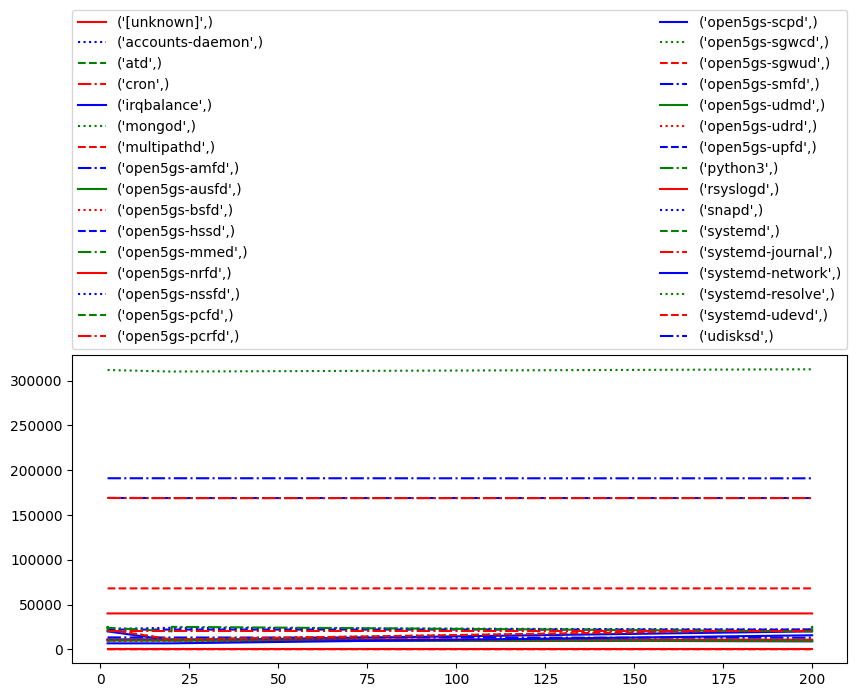

In [7]:
sysprocess_df = spark.read.option("basePath", basePath).json(
f"{basePath}/ues=*/tool=sysprocess")
# sysprocess_fig = px.line(sysprocess_df.toPandas().sort_values('ues'),
#                 x="ues", y="time (ms)", color="comm",
#                 hover_data=["count", "time (ms)"],
#                 labels={
#                      "ues": "Number of UEs",
#                      "time (ms)": "Time (ms)",
#                      "syscall": "System calls",
#                      "count": "Number of calls",
#                      "comm": "Process name"
#                 },
#                 title=f'Processes making syscall (by latency)')
fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']

colors = ['r', 'b', 'g']

i = 0
c = 0

for key, grp in pd.groupby(['comm']):
    # print(i)
    ax.plot(grp['ues'], grp['time (ms)'], label=key, color=colors[c], linestyle=linestyle_str[i])
    i = (i + 1) % len(linestyle_str)
    c = (c + 1) % len(colors)

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)
# ax.legend()
plt.show()

# pd.set_index('ues', inplace=True)
# pd.groupby('comm')['time (ms)'].plot(legend=True)

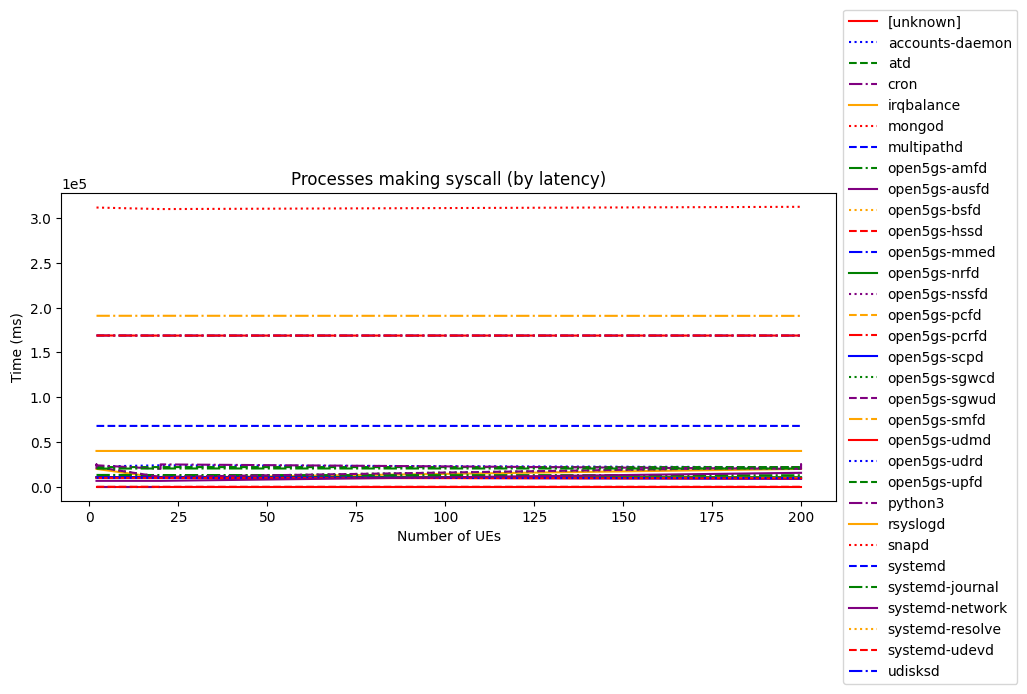

In [8]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['red', 'blue', 'green', 'purple', 'orange']

styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

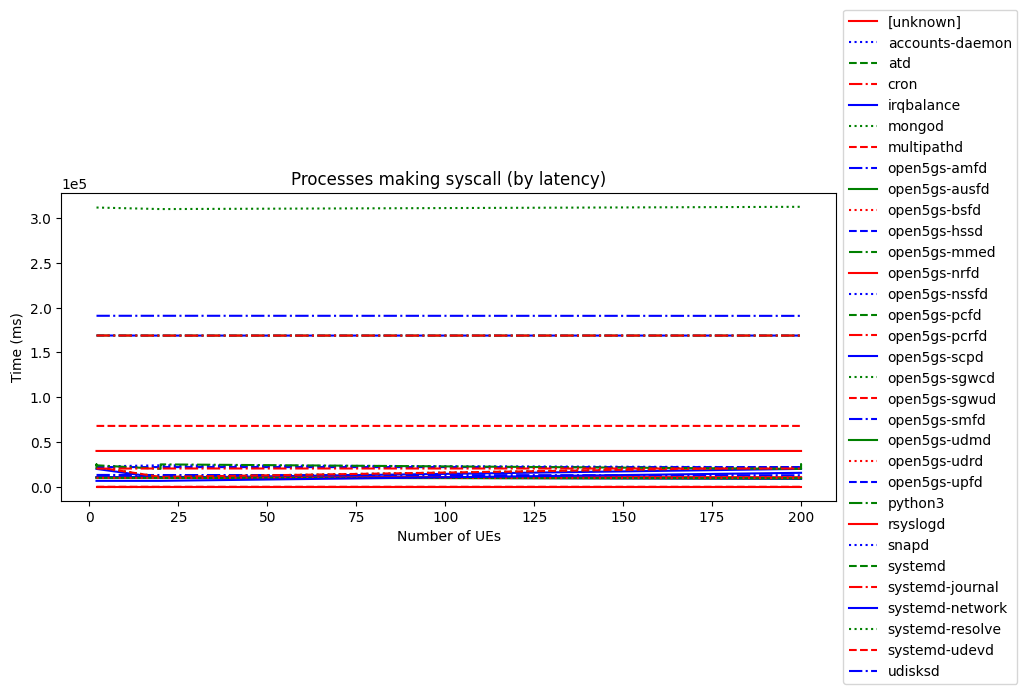

In [9]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['r', 'b', 'g']
styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

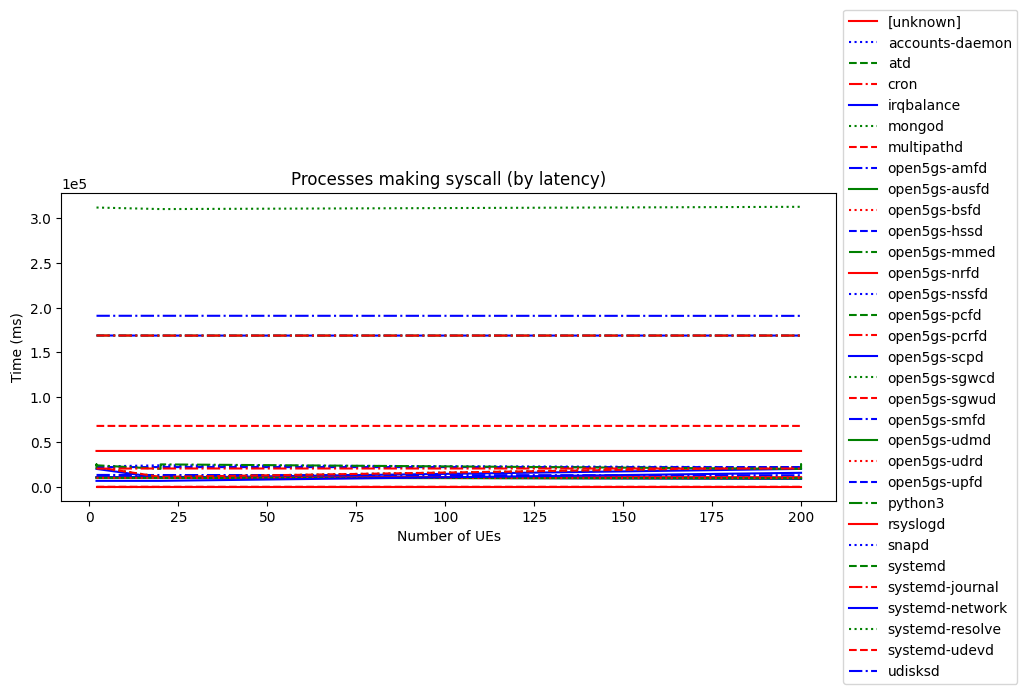

In [10]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['r', 'b', 'g']
styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.12, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# # Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=3)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.rcParams.update({'font.size': 14})
plt.show()

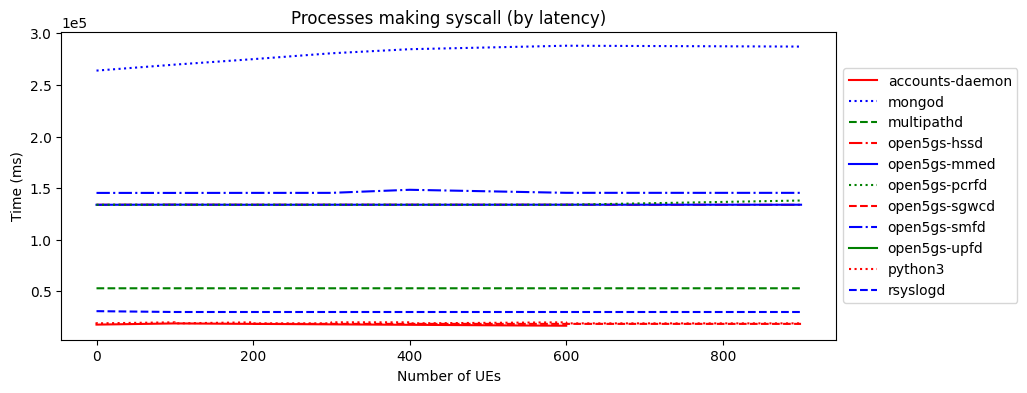

In [ ]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['r', 'b', 'g']
styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

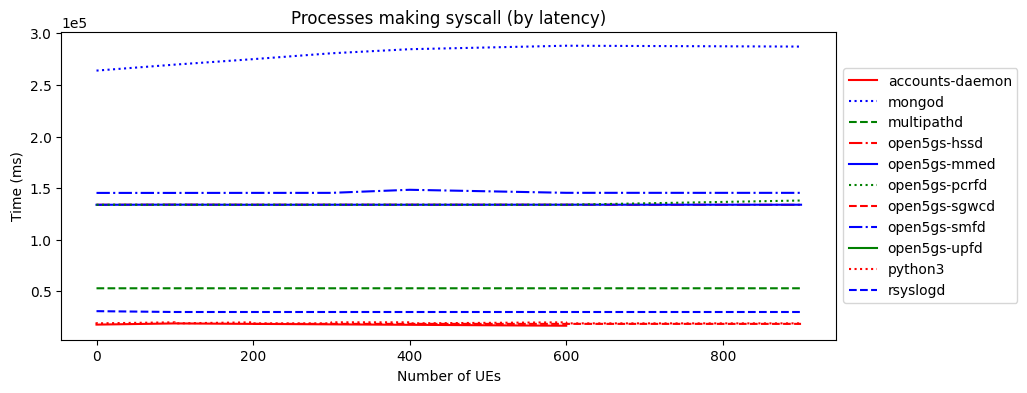

In [ ]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['r', 'b', 'g']
styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

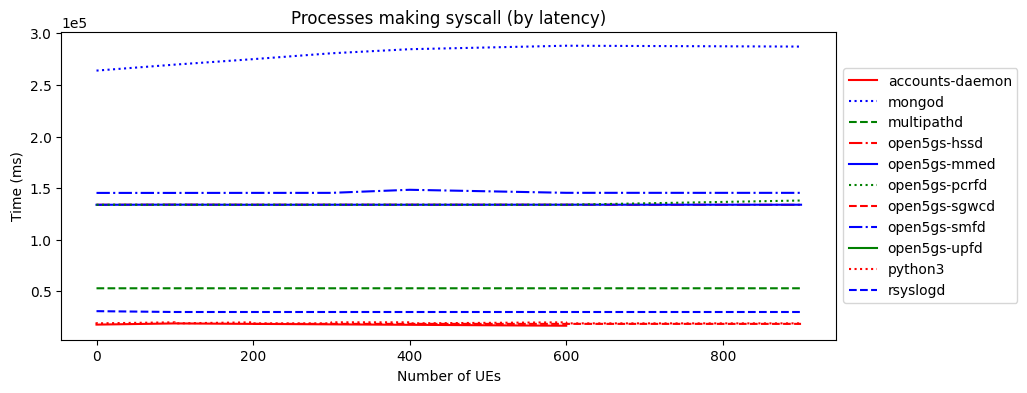

In [ ]:
import itertools


fig, ax = plt.subplots(figsize=(10,4))
pd = sysprocess_df.toPandas().sort_values('ues')
linestyle_str = ['-', ':', '--', '-.']
colors = ['r', 'b', 'g']
styles = zip(itertools.cycle(linestyle_str), itertools.cycle(colors))
for i, (key, grp) in enumerate(pd.groupby(['comm'])):
    style = next(styles)
    ax.plot(grp['ues'], grp['time (ms)'], label=key[0], color=style[1], linestyle=style[0])

# Put a legend on top of axis
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                       ncols=3, mode="expand", borderaxespad=0.)

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# Put legend on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Processes making syscall (by latency)')
plt.xlabel("Number of UEs")
plt.ylabel("Time (ms)")
# plt.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3),
#                        useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

In [14]:
sysprocess_df = spark.read.option("basePath", basePath).json(
f"{basePath}/ues=*/tool=sysprocess")
sysprocess_fig = px.line(sysprocess_df.toPandas().sort_values('ues'),
                x="ues", y="time (ms)", color="comm",
                hover_data=["count", "time (ms)"],
                labels={
                     "ues": "Number of UEs",
                     "time (ms)": "Time (ms)",
                     "syscall": "System calls",
                     "count": "Number of calls",
                     "comm": "Process name"
                },
                title=f'Processes making syscall (by latency)')
# sysprocess_fig.update_traces(textinfo='value')
sysprocess_fig.show()
sysprocess_fig.write_image(f"images/sysprocess_fig_m2.medium.jpeg")
with open(html_output_file, 'a') as f:
    f.write(f'<h2 id="syscall-processes"> Processes are making syscalls with latency information </h2>')
    f.write('<p>  </p>') 
    f.write(sysprocess_fig.to_html(full_html=False, include_plotlyjs='cdn'))
sysprocess_count_fig = px.line(sysprocess_df.toPandas().sort_values('ues'),
                x="ues", y="count", color="comm",
                hover_data=["count", "time (ms)"],
                labels={
                     "ues": "Number of UEs",
                     "time (ms)": "Time (ms)",
                     "syscall": "System calls",
                     "count": "Number of calls",
                     "comm": "Process name"
                },
                title=f'Processes making syscall (by number of calls)')
# sysprocess_count_fig.update_traces(textinfo='value')
sysprocess_count_fig.show()
sysprocess_count_fig.write_image(f"images/sysprocess_count_fig_m2.medium.jpeg")
with open(html_output_file, 'a') as f:
    f.write(f'<h2 id="syscall-count-processes"> Processes are making syscalls by number of calls</h2>')
    f.write('<p>  </p>') 
    f.write(sysprocess_count_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [11]:
syscalls = ['futex', 'clock_nanosleep', 'epoll_wait', 'poll', 'ppoll', 'recvmsg', 'recvfrom', 
            'sendto', 'read', 'openat', 'select', 'sched_yield',
            'fdatasync', 'write', 'nanosleep', 'io_getevents', 'epoll_pwait', 'rt_sigtimedwait']

# Run for each syscall
for syscall in syscalls:
    sysprocess_df = spark.read.option("basePath", basePath).json(
    f"{basePath}/ues=*/tool=sysprocess_{syscall}")
    sysprocess_fig = px.line(sysprocess_df.toPandas().sort_values('ues'),
                    x="ues", y="time (ms)", color="comm", 
                    hover_data=["count", "time (ms)"],
                    labels={
                        "ues": "Number of UEs",
                        "time (ms)": "Time (ms)",
                        "syscall": "System calls",
                        "count": "Number of calls",
                        "comm": "Process name"
                    },
                    title=f'Processes making {syscall} syscall (by latency)')
    # sysprocess_fig.update_traces(textinfo='value')
    sysprocess_fig.show()
    sysprocess_fig.write_image(f"images/sysprocess_{syscall}_fig_m2.medium.jpeg")
    with open(html_output_file, 'a') as f:
        f.write(f'<h2 id="{syscall}-syscall-processes"> Processes are making {syscall} syscalls with latency information </h2>')
        f.write('<p>  </p>') 
        f.write(sysprocess_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    sysprocess_count_fig = px.line(sysprocess_df.toPandas().sort_values('ues'),
                    x="ues", y="count", color="comm",
                    hover_data=["count", "time (ms)"],
                    labels={
                        "ues": "Number of UEs",
                        "time (ms)": "Time (ms)",
                        "syscall": "System calls",
                        "count": "Number of calls",
                        "comm": "Process name"
                    },
                    title=f'Processes making {syscall} syscall (by number of calls)')
    # sysprocess_count_fig.update_traces(textinfo='value')
    sysprocess_count_fig.show()
    sysprocess_count_fig.write_image(f"images/sysprocess_count_{syscall}_fig_m2.medium.jpeg")
    with open(html_output_file, 'a') as f:
        f.write(f'<h2 id="{syscall}-syscall-count-processes"> Processes are making {syscall} syscalls by number of calls</h2>')
        f.write('<p>  </p>') 
        f.write(sysprocess_count_fig.to_html(full_html=False, include_plotlyjs='cdn'))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [13]:
reg_df = pd.read_csv("./time_to_reg.csv")
print(reg_df)
reg_free5gc_df = reg_df[reg_df['CN'] == 'free5gc']
reg_other_df = reg_df[reg_df['CN'] != 'free5gc']
reg_fig = px.line(reg_other_df.sort_values('Ues'),
                x="Ues", y="Average", color="CN",
                # hover_data=["count", "time (ms)"],
                labels={
                     "Ues": "Number of UEs",
                     "Average": "Time (s)",
                     "syscall": "System calls",
                     "CN": "5GC"
                },
                title=f'Time taken to complete registration of UEs (Open5gs and OAI)')
reg_fig.show()
reg_fig.write_image(f"images/reg_other_fig_m2.medium.jpeg")

reg_free5gc_fig = px.line(reg_free5gc_df.sort_values('Ues'),
                x="Ues", y="Average", color="CN",
                # hover_data=["count", "time (ms)"],
                labels={
                     "Ues": "Number of UEs",
                     "Average": "Time (s)",
                     "syscall": "System calls",
                     "CN": "5GC"
                },
                title=f'Time taken to complete registration of UEs (free5gc)')
reg_free5gc_fig.show()
reg_free5gc_fig.write_image(f"images/reg_free5gc_fig_m2.medium.jpeg")

         CN  Ues    Time1    Time2    Time3    Average
0       OAI  100   3.6508   3.1262   4.0930   3.623333
1       OAI  200   6.6885   6.6100   6.9229   6.740467
2       OAI  300  13.2500  11.2785  11.7257  12.084733
3       OAI  400  19.0086  15.8515  17.1894  17.349833
4       OAI  500  22.8776  19.2067  22.6749  21.586400
5   Open5gs  100   3.1808   3.1842   3.1213   3.162100
6   Open5gs  200   7.4449   7.0096   7.4458   7.300100
7   Open5gs  300  11.1484  11.5540  10.2734  10.991933
8   Open5gs  400  16.6867  15.7139  15.5236  15.974733
9   Open5gs  500  21.2806  19.3675  21.8457  20.831267
10  free5gc   10   0.6717   0.6717   0.6717   0.671700
11  free5gc   20   1.2796   1.2796   1.2796   1.279600
12  free5gc   30   2.9802   2.9802   2.9802   2.980200
13  free5gc   40   2.7587   2.7587   2.7587   2.758700
14  free5gc   50   3.3743   3.3743   3.3743   3.374300


In [8]:
with open(html_output_file, 'a') as f:
    f.write('<h2 id="cpu-metrics"> CPU Metrics </h2>')
    f.write('<p> To analyse the performance of the CPU along with the performance of the processes, kernel routines or interrupt routines, it is essential to look at some key insights from the performance data. Firstly, it is necessary to know <em>the processes that have run and their age/lifespan</em>. This can also be used to identify issues with short-lived processes. After which, it is essential to look at the <em>time each of the methods spends waiting for its turn on the CPU</em>. Given this information, we can also find the time that the processes spend off-CPU either voluntary or involuntary leaving the CPU, lastly in cases where we see performance issues from this data, e.g., a process consuming a lot of time on-CPU or a process spending a lot of time off-CPU. It would be helpful to analyse all <em>code paths that are consuming CPU resources</em> and the <em>code path resulting in the process being off-CPU</em>.</p>')
    f.write('<p> As mentioned earlier, another CPU resource outside time is the CPU cache. This can also be a factor for processes with multiple lifespans. To diagnose this, it is essential to get the <em>number of cache misses of the LLC</em> as well as <em>the hit ratios of the LLC</em>. However this two metrics cannot be collected on virtual machines like in the case of Cloud-Based NFVI.  The prototyping system in this study collects, and presents this data, both as summary graphs and raw data from analysis </p>')

In [9]:
from pyspark.sql.window import Window

def to_long(df, by):
    """ Transposes the key pair values from the json file to a long format """
    # Source: https://stackoverflow.com/questions/37864222/transpose-column-to-row-with-spark
    # TODO: for Spark >= 3.4 use the built-in melt function
    # logs_df.melt(
    #     ids=["id"], values=json_columns,
    #     variableColumnName="key", valueColumnName="val"
    # )

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("val")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.key", "kvs.val"])

schema = StructType([
  StructField('NULL', IntegerType(), True),
  StructField('DEREGISTERED', IntegerType(), True),
  StructField('REGISTERED_INITIATED', IntegerType(), True),
  StructField('REGISTERED', IntegerType(), True),
  StructField('DEREGISTERED_INITIATED', IntegerType(), True),
  StructField('SERVICE_REQUEST_INITIATED', IntegerType(), True),
  StructField('AUTHENTICATED_INITIATED', IntegerType(), True),
  StructField('AUTHENTICATED', IntegerType(), True),
  StructField('SECURITY_MODE_INITIATED', IntegerType(), True),
  StructField('SECURITY_MODE_COMPLETED', IntegerType(), True)
])
core_tg_log_pattern = r'(\{.+\})'
logs_df = spark.read.option("basePath", "../ansible/.results").text("../ansible/.results/ues=*/tool=syscount/core-tg.log").withColumn('id', monotonically_increasing_id())
# For each monotonically increasing id, per kpps value convert id to numeric index

logs_df = logs_df.select('id', 'ues', regexp_extract('value', core_tg_log_pattern, 1).alias('value'))
logs_df = logs_df.select('id', 'ues', from_json('value', schema).alias('value'))
logs_df = logs_df.select('id', 'ues', 'value.*')

logs_df = to_long(logs_df, ["id", "ues"])
logs_df = logs_df.withColumn('value', logs_df['val'].cast(IntegerType()))

# Get max value for each kpps value and subtract from the current value to get the difference
# This is to get the difference between the current value and the previous value
logs_df = logs_df.withColumn("min", min("id").over(Window.partitionBy("ues")))
logs_df = logs_df.withColumn("diff", logs_df["id"] - logs_df["min"])
logs_df.show()


# Draw category plot using plotly
logs_df_fig = px.sunburst(logs_df.orderBy(col('id')).toPandas(), path=['ues', 'diff', 'key'], values='value',
                  color='key', hover_data=['value'],
                  title="Logs from core-tg.log")
logs_df_fig.show()

# Draw last value only diff = 13
logs_df_fig = px.sunburst(logs_df.filter(col('diff') == 13).orderBy(col('id')).toPandas(), path=['ues', 'key'], values='value',
                  color='key', hover_data=['value'],
                  title="Logs from core-tg.log")

logs_df_fig.show()


+-----------+---+--------------------+---+-----+-----------+----+
|         id|ues|                 key|val|value|        min|diff|
+-----------+---+--------------------+---+-----+-----------+----+
|25769803776|300|                NULL|  2|    2|25769803776|   0|
|25769803776|300|        DEREGISTERED|  0|    0|25769803776|   0|
|25769803776|300|REGISTERED_INITIATED|  5|    5|25769803776|   0|
|25769803776|300|          REGISTERED|  0|    0|25769803776|   0|
|25769803776|300|DEREGISTERED_INIT...|  0|    0|25769803776|   0|
|25769803776|300|SERVICE_REQUEST_I...|  0|    0|25769803776|   0|
|25769803776|300|AUTHENTICATED_INI...|  0|    0|25769803776|   0|
|25769803776|300|       AUTHENTICATED|  0|    0|25769803776|   0|
|25769803776|300|SECURITY_MODE_INI...|  0|    0|25769803776|   0|
|25769803776|300|SECURITY_MODE_COM...|  0|    0|25769803776|   0|
|25769803777|300|                NULL|187|  187|25769803776|   1|
|25769803777|300|        DEREGISTERED|  0|    0|25769803776|   1|
|257698037

In [10]:
oncpudist_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=oncpudist").select(
    "kpps", "ts", "val_type", "tool",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
oncpudist_fig_1 = px.bar(oncpudist_df.toPandas(), x="interval", y="count", color="kpps", barmode="group",
        title="Time spent by tasks on the CPU before being descheduled",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
oncpudist_fig_1.show()
oncpudist_fig_1.write_image("images/oncpudist_fig_1.jpeg")
oncpudist_fig_2 = px.bar(oncpudist_df.toPandas(), x="interval", y="count", barmode="group",
        facet_col="kpps",
        title="Time spent by tasks on the CPU before being descheduled",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
oncpudist_fig_2.show()
oncpudist_fig_2.write_image("images/oncpudist_fig_2.jpeg")
with open(html_output_file, 'a') as f:
    f.write(oncpudist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(oncpudist_fig_2.to_html(full_html=False, include_plotlyjs='cdn'))

AnalysisException: Path does not exist: file:/home/tariro/Documents/phd/opengilan/.results/oai/kpps=*/tool=oncpudist

In [ ]:
offcpudist_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=offcpudist").select(
    "kpps", "ts", "val_type", "tool",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
offcpudist_fig_1 = px.bar(offcpudist_df.toPandas(), x="interval", y="count", color="kpps", barmode="group",
        title="Time spent by tasks waiting for their turn to run on-CPU",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
offcpudist_fig_1.show()
offcpudist_fig_1.write_image("images/offcpudist_fig_1.jpeg")
offcpudist_fig_2 = px.bar(offcpudist_df.toPandas(), x="interval", y="count", barmode="group",
        facet_col="kpps",
        title="Time spent by tasks waiting for their turn to run on-CPU",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
offcpudist_fig_2.show()
offcpudist_fig_2.write_image("images/offcpudist_fig_2.jpeg")
with open(html_output_file, 'a') as f:
    f.write(offcpudist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(offcpudist_fig_2.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<div><a href="#profile">See code paths that are consuming CPU resources</a></div>')

In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<div><a href="#offcputime">See code paths casing processes to go Off-CPU</a></div>')

In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<h2 id="memory-metrics"> Memory Metrics </h2>')
    f.write('<p> Memory operations can be frequent; therefore, to reduce overheads, it is important to look at some of the non-frequent events that can give insights into the performance of the memory resource. The relatively infrequent activities are: <em>brk()</em> and <em>mmap()</em> calls, <em>page faults</em>, and <em>page-outs</em>. An important is to know the number of memory requests that result in a new segment on the heap, i.e., <em>requests for mappings</em>. Following, it is beneficial to know the <em>code path responsible for heap extension</em> which can review the portion that resulted in extending the heap. Another import operation is page fault, which results in latency and growth of a process RSS. Likewise, it is important to know the <em>code path responsible for page faults</em>. As the system reclaims memory, we would also want to know the <em>process affected and the latency: the time taken for the reclaim</em>. </p>')

In [ ]:
# data_df = spark.read.option("basePath", basePath).json(
# f"{basePath}/kpps=*/tool=sys_enter_brk")

# schema = StructType([
#   StructField('type', StringType(), True),
#   StructField('kpps', StringType(), True),
#   StructField('count', IntegerType(), True),
#   StructField('process', IntegerType(), True),
#   ])

# #Create empty DataFrame directly.
# sys_enter_brk_df = spark.createDataFrame([], schema)

# columns = data_df.select("data.@.*").columns
# data_df = data_df.select("*", "data.@.*").drop("data")
# data_df.show()
# for c in columns:
#   try:
#     df = data_df.select("type", "kpps", col(c).alias('count')).withColumn('process', lit(c))
#     sys_enter_brk_df = sys_enter_brk_df.union(df)
#   except:
#     print("Failed to find {</em>".format(c))

# sys_enter_brk_df.show()
# sys_enter_brk_fig = px.sunburst(sys_enter_brk_df.orderBy(col('kpps')).toPandas(), path=['kpps', 'process'], values='count',
#                   color='process', hover_data=['count'],
#                   title="Processes responsible for heap extension")
# sys_enter_brk_fig.show()
# sys_enter_brk_fig.write_image("images/sys_enter_brk.jpeg")
# sys_enter_brk_fig_2 = px.pie(sys_enter_brk_df.toPandas(), values='count', names='process',
#                 facet_col="kpps",
#                 title="Processes responsible for heap extension")
# # cachetop_fig_pie.update_traces(textinfo='value')
# sys_enter_brk_fig_2.show()
# sys_enter_brk_fig_2.write_image("images/sys_enter_brk_fig_2.jpeg")
# with open(html_output_file, 'a') as f:
#     f.write(sys_enter_brk_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<div><a href="#page_fault_user">See user code path responsible for page faults</a></div>')
    f.write('<div><a href="#page_fault-kernel">See kernel code path responsible for page faults</a></div>')

In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<h2 id="filesystem-metrics"> Filesystem Metrics </h2>')
    f.write('<p> Firstly, we would want to <em>characterisation virtual file system operations</em>. This helps us know what the process is spending the most time doing on the filesystem - reads and writes (I/O), creates, opens, and syncs. After that, it is essential to know the size of data in for the <em>read and write operations by the process names</em>. This can assist in diagnosing the process responsible for the degraded filesystem performance in such cases. In the same manner, in the case of frequent VFS open operation, it is essential to know the <em>processes responsible for opening files</em>. While the earlier results can help in understanding the processes, it is also necessary to know the <em>filenames with the most frequently read and written</em>. This at a high level can expose some configuration errors, for example, verbose logging in production. This is the case for the Bind9 VNF in our case. Since sockets are also perceived as filenames, this can also show the frequency of sockets reads and writes. As mentioned earlier, the filesystem uses cache to avoid exposing disk I/O latency; therefore, another critical performance factor to consider is how the stock is performing. Applications are affected mainly by page cache; examining <em>the page cache hit ratio over time</em> can give insights on the NFV configuration tuning needed.</p>')

In [ ]:
ext4dist_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=ext4dist").select(
    "kpps", "ts", "val_type", "tool", "operation",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "operation", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
ext4dist_fig_1 = px.bar(ext4dist_df.toPandas(), x="operation", y="count", barmode="group",
        facet_col="kpps",
        title="High-level workload characterization of virtual file system operations",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
ext4dist_fig_1.show()
ext4dist_fig_1.write_image("images/ext4dist_fig_1.jpeg")
ext4dist_fig_2 = px.bar(ext4dist_df.toPandas(), x="interval", y="count", color="kpps", barmode="group",
        title="Latency of ext4 operations", facet_col="operation",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
ext4dist_fig_2.show()
ext4dist_fig_2.write_image("images/ext4dist_fig_2.jpeg")
ext4dist_fig_3 = px.bar(ext4dist_df.toPandas(), x="interval", y="count", barmode="group",
        facet_col="kpps", facet_row="operation",
        title="Latency of ext4 operations",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
ext4dist_fig_3.show()
ext4dist_fig_3.write_image("images/ext4dist_fig_3.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="filesystem-ext4dist"> Latency of ext4 operations  </h2>')
    f.write('<p> This spans everything: block device I/O (disk I/O), file system CPU cycles, file system locks, run queue latency, etc. \
        It gives a measure of the latency suffered by an application reading from filesytem. This is a good starting point in understanding \
        if the application\'s performance is affected or dependenat on the file system. In cases where the applications performance is impacted \
        by filesystem access, the results below along with the results from the Disk I/O should be analysed to get a better observability of the \
        points of performance degradation.\
        This on shows common file system operations: reads, writes, opens, and fsyncs </p>')
    f.write(ext4dist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(ext4dist_fig_2.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
filetop_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=filetop")
unpivotExpr = "stack(2, 'rbytes', rbytes, 'wbytes', wbytes) as (operation,bytes)"
filetop_df_1 = filetop_df.select("kpps", "writes", "reads", "comm", "file", "type", expr(unpivotExpr)) \
    .where("bytes is not null")
filetop_df = filetop_df.where(col("_corrupt_record").isNull()).drop("_corrupt_record")
# Reads
filetop_read_fig = px.sunburst(filetop_df.toPandas(), path=['kpps', 'file'], values='reads',
                  color='file', hover_data=['rbytes'],
                  title="Most frequently read filenames - including TCP sockets",
                  labels={
                    "kpps": "Packets Per Second (thousand)",
                    "reads": "Number of file reads",
                    "file": "File names"
                })
filetop_read_fig.show()
filetop_read_fig.write_image("images/filetop_read_fig.jpeg")
filetop_write_fig = px.sunburst(filetop_df.toPandas(), path=['kpps', 'file'], values='writes',
                  color='file', hover_data=['wbytes'],
                  title="Most frequently written filenames - including sockets",
                  labels={
                    "kpps": "Packets Per Second (thousand)",
                    "reads": "Number of file reads",
                    "file": "File names"
                })
filetop_write_fig.show()
filetop_write_fig.write_image("images/filetop_write_fig.jpeg")
filetop_fig = px.scatter(filetop_df_1.toPandas(), x="writes", y="reads", size="bytes", color="comm",
           log_x=True, facet_col="kpps", facet_row="type", hover_data=["file"],
           title="Scatter distribution of files being read or written to by processes and byte sizes")
filetop_fig.show()

with open(html_output_file, 'a') as f:
    f.write('<h2 id="filesystem-filetop"> Reads and writes by file, with process details  </h2>')
    f.write('<p> This is instrumenting at the VFS interface, so this is reads and writes that may return entirely from \
        the file system cache (page cache). Type refers to the type of file: R for regular files, S for sockets, and O \
        for other (including pipes). The results are from vfs operations hence if files are read or written to using \
        another means (e.g., via mmap()) they don\'t appear in these results. </p>')
    f.write(filetop_read_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(filetop_write_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(filetop_fig.to_html(full_html=False, include_plotlyjs='cdn'))

/home/tariro/Documents/phd/opengilan/.venv/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/tariro/Documents/phd/opengilan/.venv/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/home/tariro/Documents/phd/opengilan/.venv/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/tariro/Documents/phd/opengilan/.venv/lib/python3.8/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
cachestat_df_1 = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=cachestat/*.json")
unpivotExpr = "stack(3, 'hits', hits, 'misses', misses, 'dirties', dirties) as (operation,value)"
cachestat_df = cachestat_df_1.select("kpps", "buffers_mb", "cached_mb", expr(unpivotExpr)) \
    .where("value is not null")
cachestat_fig = px.bar(cachestat_df.toPandas(), x="operation", y=["value"], barmode='group',
            facet_col="kpps",
            title="Page cache hit vs miss ratio at different packet rate",
            labels={
                     "kpps": "Packets Per Second (thousand)",
                     "value": "Count",
                     "variable": "Cache Operation"
                 })
cachestat_fig.show()
with open(html_output_file, 'a') as f:
    f.write('<h2 id="filesystem-cachestat"> Page cache hit vs miss ratio  </h2>')
    f.write('<p> This shows the overall system cache performance for the interval and duration of the expriment. \
        The results are high level are helful in identifying if further investigation is needed. Where the number \
        of misses are many, there will be need to look further at the results below. </p>') 
    f.write(cachestat_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
cachetop_df_1 = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=cachetop")
unpivotExpr = "stack(3, 'hits', hits, 'misses', misses, 'dirties', dirties) as (operation,value)"
cachetop_df = cachetop_df_1.select("kpps", "comm", "read_hit_percent", "write_hit_percent", expr(unpivotExpr)) \
    .where("value is not null")
cachetop_fig_scatter_1 = px.scatter(cachetop_df.toPandas(), x="read_hit_percent", y="write_hit_percent", size="value", color="operation",
           hover_name="comm", log_x=False, facet_row="kpps",
           title="Page cache hit/miss and read and write hit % per process (Scatter 1)")
cachetop_fig_scatter_1.show()
cachetop_fig_scatter_1.write_image("images/cachetop_fig_scatter_1.jpeg")
cachetop_fig_scatter_2 = px.scatter(cachetop_df_1.toPandas(), x="misses", y="dirties", size="hits", color="comm",
           log_x=False, facet_row="kpps",
           title="Page cache hit/miss and read and write hit % per process (Scatter 2)" )
cachetop_fig_scatter_2.show()
cachetop_fig_scatter_2.write_image("images/cachetop_fig_scatter_2.jpeg")
cachetop_fig_scatter_3 = px.scatter(cachetop_df.toPandas(), x="read_hit_percent", y="write_hit_percent", size="value", color="comm",
        log_x=False, facet_col="operation", facet_row="kpps",
        title="Page cache hit/miss and read and write hit % per process (Scatter 3)")
cachetop_fig_scatter_3.show()
cachetop_fig_scatter_3.write_image("images/cachetop_fig_scatter_3.jpeg")
cachetop_fig_pie = px.pie(cachetop_df.toPandas(), values='value', names='comm',
                facet_col="operation", facet_row="kpps", hover_data=["read_hit_percent", "write_hit_percent"],
                title="Page cache hit/miss and read and write hit % per process (Pie)")
# cachetop_fig_pie.update_traces(textinfo='value')
cachetop_fig_pie.show()
cachetop_fig_pie.write_image("images/cachetop_fig_pie.jpeg")
cachetop_fig_bar = px.bar(cachetop_df.toPandas(), x="operation", y="value", color="comm",
                facet_row="kpps",
                title="Page cache hit/miss and read and write hit % per process (Bar)")
cachetop_fig_bar.show()
cachetop_fig_bar.write_image("images/cachetop_fig_bar.jpeg")
cachetop_fig_sunburst = px.sunburst(cachetop_df.toPandas(), path=['kpps','operation', 'comm'], values='value',
                title="Page cache hit/miss and read and write hit % per process (Sunburst)")
cachetop_fig_sunburst.show()
cachetop_fig_sunburst.write_image("images/cachetop_fig_sunburst.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="filesystem-cachetop"> Cachetop shows the page cache hit/miss and read and write hit % per process </h2>')
    f.write('<p> This shows the processes that are responsible for the most hit and misses. This enables the developers \
                to identify the processes that need further optimisation. The results also show the percentage of read \
                or write hits, which helps with identifying if the process(es) are doing more writes than reads. This can \
                expose some application configuration not meant for production e.g., a process with verbose logging. \
                It can also allow the system admin to configure the system or to pick a sytsem for the workload. </p>') 
    f.write(cachetop_fig_scatter_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(cachetop_fig_scatter_2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(cachetop_fig_scatter_3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(cachetop_fig_pie.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(cachetop_fig_bar.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(cachetop_fig_sunburst.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
df = px.data.gapminder()
df.head()

cachetop_df.toPandas().head()

,kpps,comm,read_hit_percent,write_hit_percent,operation,value
0,100,systemd-journal,100.0,0,hits,6
1,100,systemd-journal,100.0,0,misses,0
2,100,systemd-journal,100.0,0,dirties,0
3,100,mongod,100.0,0,hits,2
4,100,mongod,100.0,0,misses,0


In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<h2 id="disk-metrics"> Disk I/O Metrics </h2>')
    f.write('<p> To first evaluate the performance of Disk I/O, we would want to know the overall <em>block I/O device latency</em>. \
        This refers to the time from issuing a request to the device, to when it completes, including time spent queued in the kernel, \
        for each unique set of request flags e.g., Read, Write, Read-Ahead etc. \
        While latency can show the overall performance of the Disk I/O, to remediate them, it would be essential to get more details, like \
        (a) the <em>random/sequential disk access patterns</em> - this informs the disk mostly being used and the pattern as well as the data sizes.\
        (a) the <em>processes running and their Disk I/O requests</em>. This will help in further identifying the processes that need to be optimised. \
        (b) the <em>processes performing I/O on disk and the bite-size</em>. \
        (c) the <em>time requests were queued in the I/O scheduler in the block layer</em>.</p>')

In [ ]:
biolatency_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=biolatency").select(
    "kpps", "ts", "val_type", "tool", "flags",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "flags", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
biolatency_fig = px.bar(biolatency_df.toPandas(), x="interval", y="count", barmode="group", facet_col="flags", facet_row="kpps",
        title="Block I/O device latency",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "No. of UEs",
                    "count": "No. of I/O requests",
                    "interval": "Latency (usecs)"
                })
biolatency_fig.show()
biolatency_fig.write_image("images/biolatency.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="disk-biolatency"> Biolatency traces block device I/O (disk I/O) </h2>')
    f.write('<p> The biolatency tool traces block device I/O (disk I/O) and shows the time requests were queued in the I/O scheduler in the block layer. \
       including time spent queued in the kernel</p>') 
    f.write(biolatency_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
biotop_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=biotop")
biotop_fig = px.pie(biotop_df.toPandas(), values='avg_ms', names='comm',
                facet_col="kpps", facet_row="operation", hover_data=["kbytes", "io", "disk"],
                title='Block I/O average time (ms) per process (top 20)')
biotop_fig.update_traces(textinfo='value')
biotop_fig.show()
biotop_fig.write_image("images/biotop.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="disk-biotop"> Biotop shows the top 20 processes performing disk I/O </h2>')
    f.write('<p> This shows the top 20 processes performing disk I/O operation per given interval (specified earlier). \
        It shows the type of operation (read/write) and the average time taken in milliseconds (units are not shown on graph). \
        The average time is the total time of the operation divided by the number of I/O. \
        Hovering over the chart will show the Kbytes, number of I/O operation and the disk name. \
        \
        This information is uses for deducing the process(es) responsible or incurring the latency shown in the Block I/O device latency graph, \
        thereby enabling further optimisation. </p>') 
    f.write(biotop_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
# Where as the above shows the total bytes (after hoevering) and the average latency, it doesn't show the distribution of the bite sizes. The distribution of the bites sizes might be key to deducing the or understanding the system and hence the resources needed.
bitesize_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=bitesize").select(
    "kpps", "ts", "val_type", "tool", "comm",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "comm", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
bitesize_fig_1 = px.bar(bitesize_df.toPandas(), x="interval", y="count", barmode="group", facet_row="kpps",
        title="Block I/O size distribution",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "No. of UEs",
                    "count": "No. of I/O requests",
                    "interval": "Size (kbytes)"
                })
bitesize_fig_1.show()
bitesize_fig_1.write_image("images/bitesize_fig_1.jpeg")
bitesize_fig_2 = px.bar(bitesize_df.toPandas(), x="interval", y="count", color="comm", facet_row="kpps",
        title="Block I/O size distribution (by process name)",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "No. of UEs",
                    "count": "No. of I/O requests",
                    "interval": "Size (kbytes)"
                })
bitesize_fig_2.show()
bitesize_fig_2.write_image("images/bitesize_fig_2.jpeg")
bitesize_fig_3 = px.bar(bitesize_df.toPandas(), x="interval", y="count", barmode="group",
        facet_row="comm", facet_col="kpps",
        title="Block I/O size distribution (by process name)",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "No. of UEs",
                    "count": "No. of I/O requests",
                    "interval": "Size (kbytes)"
                })
bitesize_fig_3.show()
bitesize_fig_3.write_image("images/bitesize_fig_3.jpeg")
bitesize_fig_4 = px.bar(bitesize_df.toPandas(), x="interval", y="count", barmode="group",
        facet_row="kpps", facet_col="comm",
        title="Block I/O size distribution (by process name)",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "No. of UEs",
                    "count": "No. of I/O requests",
                    "interval": "Size (kbytes)"
                })
bitesize_fig_4.show()
bitesize_fig_4.write_image("images/bitesize_fig_4.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="disk-bitesize"> Block I/O size distribution  </h2>')
    f.write('<p> This shows the size distribution of the Block I/O. It helps in identifying the general distribution of the \
            block I/O sizes and the respective distribution per process. This helps in identifying the process(es) with larger \
            or smaller bite size IOPs for optimisation </p>') 
    f.write(bitesize_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(bitesize_fig_2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(bitesize_fig_3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(bitesize_fig_4.to_html(full_html=False, include_plotlyjs='cdn'))


In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<h2 id="networking-metrics"> Netowrking Metrics </h2>')
    f.write('<p> To draw insights on the performance of the networking on the NFV and for the VNF, the initial bit is that we will need to know the <em>number of packets being received and their sizes</em>. After that, we would want to see the <em>latency of the device queue</em>, i.e., the time from when the packets have been pushed into the device layer for sending until the packages are sent out as signalled by NAPI. After that, we would want to know the <em>time spent on the queuing disciplines</em>. Next, we would want to see the <em>latency for IP protocol connections and the process of making the connection</em>. Following this, we would also like to know the <em>lifespan of the kernel buffers</em> that are used to pass packets across the networking stack. This can show the latency within the networking stack. While this shows the latency, it won’t show the packet drops. For this, it would be essential to know <em>the number of packets and allocated size of the socket buffers and their limits</em>. Packets are dropped when the socket limits have been reached. </p>')

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
data_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=netsize")
schema = StructType([
  StructField('type', StringType(), True),
  StructField('kpps', IntegerType(), True),
  StructField('count', IntegerType(), True),
  StructField('min', IntegerType(), True),
  StructField('max', IntegerType(), True),
  StructField('device', StringType(), True),
  StructField('action', StringType(), True),
  ])

#Create empty DataFrame directly.
netsize_df = spark.createDataFrame([], schema)

types = data_df.select("data.*").columns
data_df = data_df.select("*", "data.*").drop("data")
for t in types: # for action of the actions -> e.g., recv_bytes
  columns = data_df.select("{}.*".format(t)).columns
  for c in columns: # for each device -> e.g., eth0
      df = data_df.select("type", "kpps", "tool", explode("{}.{}".format(t, c)).alias("dataExplode")).select("type", "kpps", "dataExplode.*").withColumn('device', lit(c)).withColumn('action', lit(t))
      netsize_df = netsize_df.union(df)

netsize_df = netsize_df.orderBy(col('kpps')).select("*", concat_ws(' - ',col('min'),col('max')).alias("interval"))
pd_df = netsize_df.toPandas()
pd_df['kpps'] = pd_df['kpps'].astype(str)
netsize_fig = px.bar(pd_df, x="interval", y="count", color="device", 
        facet_col="action", facet_row="kpps",
        title="Packet Distribution",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Packets",
                    "interval": "Packet Size (bytes)"
                })
netsize_fig.show()
netsize_fig.write_image("images/netsize.jpeg")
with open(html_output_file, 'a') as f:
    f.write(netsize_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
data_df = spark.read.option("basePath", basePath).json(f"{basePath}/kpps=*/tool=skblife")
schema = StructType([
  StructField('kpps', IntegerType(), True),
  StructField('type', IntegerType(), True),
  StructField('count', IntegerType(), True),
  StructField('min', IntegerType(), True),
  StructField('max', IntegerType(), True),
  StructField('interval', StringType(), True),
  ])

#Create empty DataFrame directly.
skblife_df = spark.createDataFrame([], schema)

data_df = data_df.select("*", explode('data.@skb_residency_nsecs').alias("dataExplode")).select("type", "kpps", "dataExplode.*")
data_df = data_df.orderBy(col('kpps')).select(col("kpps").cast(StringType()), "type", "count", "min", "max", concat_ws(' - ',col('min'),col('max')).alias("interval"))
skblife_df = skblife_df.union(data_df)

skblife_fig = px.bar(skblife_df.toPandas(), x="interval", y="count",
        facet_row="kpps",
        title="Distribution of lifespan or age of the kernel buffers",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of kernel buffers",
                    "interval": "Lifetime/Age (usecs)"
                })
skblife_fig.show()
skblife_fig.write_image("images/skblife.jpeg")
with open(html_output_file, 'a') as f:
    f.write(skblife_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
hardirqs_count_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=hardirqs_count")
# print(df.rdd.getNumPartitions())
import plotly.express as px
hardirqs_count_fig = px.bar(hardirqs_count_df.toPandas(), x="kpps", y="total_usecs", color="hardirq",
            title="Total time spent servicing hard IRQs (hard interrupts)",
            labels={
                    "kpps": "Packets Per Second (thousand)",
                    "total_usecs": "Time (usecs)",
                    "hardirq": "Hardware Interupts"
                })
hardirqs_count_fig.show()
hardirqs_count_fig.write_image("images/hardirqs_count.jpeg")
with open(html_output_file, 'a') as f:
    f.write(hardirqs_count_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
hardirqs_dist_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=hardirqs_dist").select(
    "kpps", "ts", "val_type", "tool", "hardirq",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "hardirq", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
import plotly.express as px
hardirqs_dist_fig_1 = px.bar(hardirqs_dist_df.toPandas(), x="interval", y="count", color="kpps", barmode="group",
        title="Distribution of Hard IRQs run time",
        hover_data=["hardirq"],
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
hardirqs_dist_fig_1.show()
hardirqs_dist_fig_1.write_image("images/hardirqs_dist_fig_1.jpeg")
hardirqs_dist_fig_2 = px.bar(hardirqs_dist_df.toPandas(), x="interval", y="count", barmode="group",
        facet_col="kpps",
        title="Distribution of Hard IRQs run time",
        hover_data=["hardirq"],
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
hardirqs_dist_fig_2.show()
hardirqs_dist_fig_2.write_image("images/hardirqs_dist_fig_2.jpeg")
with open(html_output_file, 'a') as f:
    f.write(hardirqs_dist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(hardirqs_dist_fig_2.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
softirqs_count_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=softirqs_count")
# print(df.rdd.getNumPartitions())
import plotly.express as px
softirqs_count_fig = px.bar(softirqs_count_df.toPandas(), x="kpps", y="total_usecs", color="softirq",
            title="Total time spent servicing soft IRQs",
            labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Time (usecs)",
                    "hardirq": "Hardware Interupts"
                })
softirqs_count_fig.show()
softirqs_count_fig.write_image("images/softirqs_count.jpeg")
with open(html_output_file, 'a') as f:
    f.write(softirqs_count_fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
softirqs_dist_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=softirqs_dist").select(
    "kpps", "ts", "val_type", "tool", "softirq",
    explode("data").alias("dataExplode")
).orderBy(col('kpps')).select(col("kpps").cast(StringType()), "ts", "val_type", "tool", "softirq", "dataExplode.*", concat_ws('-',col('dataExplode.interval-start'),col('dataExplode.interval-end')).alias("interval"))
import plotly.express as px
softirqs_dist_fig_1 = px.bar(softirqs_dist_df.toPandas(), x="interval", y="count", color="kpps", barmode="group",
        title="Distribution of Hard IRQs run time",
        hover_data=["softirq"],
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
softirqs_dist_fig_1.show()
softirqs_dist_fig_1.write_image("images/softirqs_dist_fig_1.jpeg")
softirqs_dist_fig_2 = px.bar(softirqs_dist_df.toPandas(), x="interval", y="count", barmode="group",
        facet_col="kpps",
        title="Distribution of Soft IRQs run time",
        hover_data=["softirq"],
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Times",
                    "interval": "Latency (usecs)"
        })
softirqs_dist_fig_2.show()
softirqs_dist_fig_2.write_image("images/softirqs_dist_fig_2.jpeg")
with open(html_output_file, 'a') as f:
    f.write(softirqs_dist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(softirqs_dist_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
tcplife_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=tcplife")
tcplife_fig_scatter_1 = px.scatter(tcplife_df.toPandas(), x="tx_kb", y="rx_kb", size="ms", color="task",
           hover_data=["daddr", "dport", "saddr", "sport"], log_x=False, facet_row="kpps",
           title="TCP sessions that open and close")
tcplife_fig_scatter_1.show()
tcplife_fig_scatter_1.write_image("images/tcplife_fig_scatter_1.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="net-tcplife"> TCP sessions that open and close while tracing </h2>')
    f.write('<p> Useful for workload characterisation and flow accounting: identifying what connections are happening, with \
        the bytes transferred. It also shows the process responsible for the TCP session open and close. The tool can be helpful \
        in understanding the latency from the TCP sessions and process that need to be optimised. </p>') 
    f.write(tcplife_fig_scatter_1.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
tcpconnlat_df = spark.read.option("basePath", basePath).json(
f"{basePath}/kpps=*/tool=tcpconnlat")
tcpconnlat_fig_1 = px.bar(tcpconnlat_df.toPandas(), x="task", y="lat (ms)", color="task",
        facet_row="kpps",
        title="Latency of TCP connections per process",
        color_discrete_sequence=px.colors.sequential.Plasma,
        labels={
                    "kpps": "Packets Per Second (thousand)",
                    "count": "Number of Processes",
                    "interval": "Latency (usecs)"
        })
tcpconnlat_fig_1.show()
tcpconnlat_fig_1.write_image("images/tcpconnlat_fig.jpeg")
with open(html_output_file, 'a') as f:
    f.write('<h2 id="net-tcpconnlat"> Latency of TCP connections per process </h2>')
    f.write('<p> Shows the latency (time) for the connection as measured locally: the time from SYN sent to the response packet. </p>') 
    f.write(tcpconnlat_fig_1.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
import base64

file_list = glob.glob('../ansible/.results/kpps=*/tool=profile/*.txt')
with open(html_output_file, 'a') as f:
    f.write('<div id="profile">')
    for file in file_list:
        try:
            kpps = re.search('../ansible/.results/kpps=(.+?)/tool=profile/(.+?).txt', file).group(1)
            os.system("../FlameGraph/flamegraph.pl --color=java --title='On-CPU Time Flame Graph for {} kpps' < {} > images/{}kpps_profile.svg".format(kpps, file, kpps))
            with open("images/{}kpps_profile.svg".format(kpps), "rb") as image_file:
                kpps_profile = str(base64.b64encode(image_file.read()),'utf-8')
                f.write('<img id="1kpps_profile" src="data:image/svg+xml;base64,{}" />'.format(kpps_profile))
        except AttributeError:
            print("Error creating profile svg files")

    f.write('</div>')



In [ ]:
with open(html_output_file, 'a') as f:
    f.write('<div id="offcputime">')
    file_list = glob.glob('../ansible/.results/kpps=*/tool=offcputime/*.txt')
    for file in file_list:
        try:
            kpps = re.search('../ansible/.results/kpps=(.+?)/tool=offcputime/(.+?).txt', file).group(1)
            os.system("../FlameGraph/flamegraph.pl --hash --bgcolors=blue --title='Off-CPU Time Flame Graph for {} kpps' < {} > images/{}kpps_offcputime.svg".format(kpps, file, kpps))
            with open("images/{}kpps_offcputime.svg".format(kpps), "rb") as image_file:
                kpps_offcputime = str(base64.b64encode(image_file.read()),'utf-8')
                f.write('<img src="data:image/svg+xml;base64,{}" />'.format(kpps_offcputime))
        except AttributeError:
            print("Error creating offcputime svg files")
    f.write('</div>')

In [ ]:

file_list = glob.glob('../ansible/.results/kpps=*/tool=page_fault_user/*.txt')
with open(html_output_file, 'a') as f:
    f.write('<div id="page_fault_user">')
    for file in file_list:
        try:
            kpps = re.search('../ansible/.results/kpps=(.+?)/tool=page_fault_user/(.+?).txt', file).group(1)
            os.system("../FlameGraph/flamegraph.pl --hash --width=800 --title='Page Fault Flame Graph for {} kpps' --colors=java --bgcolor=green < {} > images/{}kpps_page_fault_user.svg".format(kpps, file, kpps))
            with open("images/{}kpps_page_fault_user.svg".format(kpps), "rb") as image_file:
                kpps_page_fault_user = str(base64.b64encode(image_file.read()),'utf-8')
                f.write('<img src="data:image/svg+xml;base64,{}" />'.format(kpps_page_fault_user))
        except AttributeError:
            print("Error creating page_fault_user svg files")
    f.write('</div>')

In [ ]:
file_list = glob.glob('../ansible/.results/kpps=*/tool=page_fault_kernel/*.txt')
with open(html_output_file, 'a') as f:
    f.write('<div id="page_fault_kernel">')
    for file in file_list:
        try:
            kpps = re.search('../ansible/.results/kpps=(.+?)/tool=page_fault_kernel/(.+?).txt', file).group(1)
            os.system("../FlameGraph/flamegraph.pl --hash --width=800 --title='Kernel Page Fault Flame Graph for {} kpps' --colors=java --bgcolor=green < {} > images/{}kpps_page_fault_kernel.svg".format(kpps, file, kpps))
            with open("images/{}kpps_page_fault_kernel.svg".format(kpps), "rb") as image_file:
                kpps_page_fault_kernel = str(base64.b64encode(image_file.read()),'utf-8')
                f.write('<img src="data:image/svg+xml;base64,{}" />'.format(kpps_page_fault_kernel))
        except AttributeError:
            print("Error creating page_fault_kernel svg files")
    f.write('</div>')